# Pycaret for Model Selection

In [7]:
# !pip install pycaret
# !pip install optuna
!pip install optuna-integration[sklearn]

In [2]:
from pycaret.regression import *
import pandas as pd

In [11]:
# Load and preprocess data
def load_and_preprocess_data(source: str, target_col: str) -> pd.DataFrame:
    df = pd.read_csv(source, parse_dates=['Date'])
    df.rename(columns={'Date': 'date'}, inplace=True)
    df = df.sort_values('date')
    
    # Drop target variable NaN values
    df.dropna(subset=[target_col], inplace=True)

    # Drop mortgage rate column (if using diff as target)
    if target_col == 'MORTGAGE30US_diff':
        df.drop(columns=['MORTGAGE30US'], inplace=True, errors='ignore')
    elif target_col == 'MORTGAGE30US':
        df.drop(columns=['MORTGAGE30US_diff'], inplace=True, errors='ignore')
    
    return df

# Feature engineering
def create_features(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['weekofyear'] = df['date'].dt.isocalendar().week
    df['rolling_mean_3'] = df[target_col].rolling(window=3).mean()
    df['rolling_std_3'] = df[target_col].rolling(window=3).std()

    # drop date column
    df.drop(columns=['date'], inplace=True)

    # Convert everything to float32
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')
        else:
            df[col] = df[col].astype('float32')
    return df

In [4]:
# Run PyCaret pipeline
def run_pycaret_pipeline(source: str, target_col: str):
    # Load and preprocess data
    df = load_and_preprocess_data(source, target_col)
    df = create_features(df, target_col)
    
    # Drop unnecessary columns
    df = df.drop(columns=['date'])
    
    # Initialize PyCaret setup
    reg_setup = setup(
        data=df,
        target=target_col,
        session_id=42,
        fold=10,
        use_gpu=False,
        categorical_imputation='drop',
        numeric_imputation='drop',
        normalize=True,
        transformation=False,
        feature_selection=False,
        remove_multicollinearity=False,
        # ignore_features=['rolling_mean_3', 'rolling_std_3'],
    )
    
    # Compare models and select the best one
    best_model = compare_models()
    
    # Tune the best model
    tuned_model = tune_model(best_model)

    # predict on test set
    holdout_pred = predict_model(tuned_model) 
    
    # Evaluate the tuned model
    evaluate_model(tuned_model)
    
    # Finalize the model
    final_model = finalize_model(tuned_model)
    
    # Save the model
    save_model(final_model, '../models/pycaret_final_mortgage_rate_model')
    
    return final_model


,Description,Value
0,Session id,42
1,Target,MORTGAGE30US_diff
2,Target type,Regression
3,Original data shape,"(2822, 42)"
4,Transformed data shape,"(1844, 42)"
5,Transformed train set shape,"(1287, 42)"
6,Transformed test set shape,"(557, 42)"
7,Numeric features,41
8,Rows with missing values,34.7%
9,Preprocess,True


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0376,0.0027,0.0519,0.7097,0.0405,0.8722,0.0200
lr,Linear Regression,0.0377,0.0027,0.0521,0.7071,0.0406,0.8851,0.9090
huber,Huber Regressor,0.0400,0.0032,0.0560,0.6639,0.0433,0.9058,0.0420
ridge,Ridge Regression,0.0411,0.0033,0.0574,0.6461,0.0454,0.8592,0.0210
omp,Orthogonal Matching Pursuit,0.0532,0.0054,0.0735,0.4201,0.0543,1.0784,0.0200
par,Passive Aggressive Regressor,0.0607,0.0069,0.0818,0.2640,0.0566,1.3415,0.0180
gbr,Gradient Boosting Regressor,0.0578,0.0070,0.0837,0.2454,0.0603,1.1222,0.4530
ada,AdaBoost Regressor,0.0595,0.0071,0.0841,0.2415,0.0632,1.0687,0.1820
lightgbm,Light Gradient Boosting Machine,0.0604,0.0075,0.0865,0.1964,0.0596,1.2069,0.3560
rf,Random Forest Regressor,0.0609,0.0076,0.0872,0.1839,0.0608,1.2110,1.2410


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0395,0.0027,0.0524,0.6800,0.0428,0.8395
1,0.0330,0.0019,0.0440,0.8040,0.0357,0.7856
2,0.0373,0.0030,0.0548,0.6799,0.0374,0.8245
3,0.0420,0.0034,0.0582,0.6630,0.0454,0.9260
4,0.0379,0.0027,0.0519,0.6593,0.0388,1.0218
5,0.0331,0.0019,0.0432,0.7918,0.0362,0.6994
6,0.0377,0.0027,0.0523,0.6708,0.0407,1.1667
7,0.0385,0.0029,0.0536,0.7371,0.0425,0.7672
8,0.0398,0.0031,0.0557,0.7093,0.0425,0.8142


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0396,0.0028,0.0526,0.7545,0.0414,0.9668


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

Transformation Pipeline and Model Successfully Saved


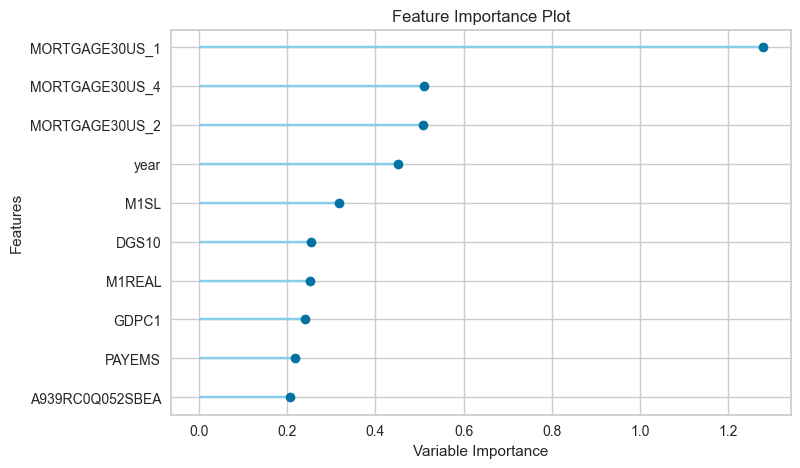

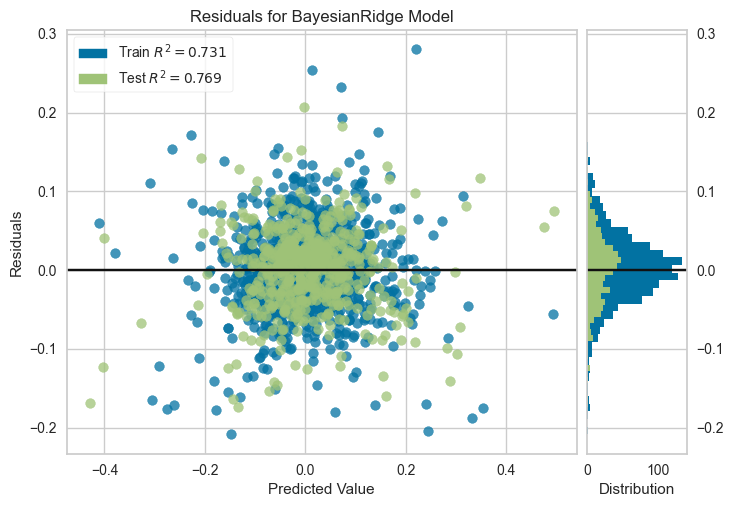

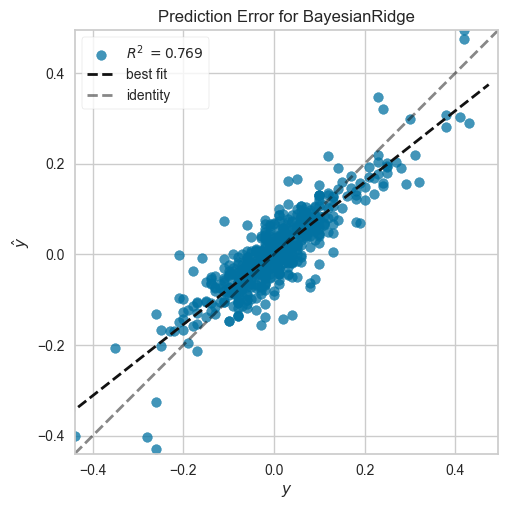

In [5]:
# Run the pipeline
if __name__ == "__main__":
    target_col = 'MORTGAGE30US_diff'
    source = '../data/full_mortgage_dataset.csv'
    final_model = run_pycaret_pipeline(source, target_col)

    plot_model(final_model, plot='feature')
    plot_model(final_model, plot='residuals')
    plot_model(final_model, plot='error')

,Description,Value
0,Session id,42
1,Target,MORTGAGE30US_diff
2,Target type,Regression
3,Original data shape,"(2822, 42)"
4,Transformed data shape,"(2822, 42)"
5,Transformed train set shape,"(1975, 42)"
6,Transformed test set shape,"(847, 42)"
7,Ignore features,1
8,Numeric features,41
9,Preprocess,True


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0485,0.0052,0.0723,0.6107,0.0532,1.0531
1,0.0447,0.0043,0.0657,0.5005,0.0498,1.0349
2,0.0541,0.0060,0.0776,0.6173,0.0593,1.0170
3,0.0444,0.0042,0.0648,0.5714,0.0486,0.9025
4,0.0481,0.0045,0.0672,0.4319,0.0490,1.0258
5,0.0526,0.0112,0.1060,-0.2170,0.0745,1.2115
6,0.0469,0.0045,0.0671,0.5054,0.0525,1.2907
7,0.0487,0.0044,0.0667,0.5709,0.0525,0.9905
8,0.0490,0.0045,0.0668,0.5876,0.0528,0.9092


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,0.0484,0.0052,0.0721,0.6130,0.0531,1.0522
1,0.0448,0.0043,0.0657,0.5009,0.0499,1.0399
2,0.0540,0.0060,0.0776,0.6175,0.0594,1.0165
3,0.0443,0.0042,0.0647,0.5734,0.0485,0.9023
4,0.0481,0.0045,0.0671,0.4334,0.0489,1.0258
5,0.0529,0.0130,0.1142,-0.4119,0.0777,1.2531
6,0.0469,0.0045,0.0670,0.5067,0.0524,1.2936
7,0.0486,0.0044,0.0666,0.5726,0.0524,0.9901
8,0.0489,0.0044,0.0666,0.5897,0.0527,0.9107


Fitting 10 folds for each of 500 candidates, totalling 5000 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
Ridge(random_state=42)


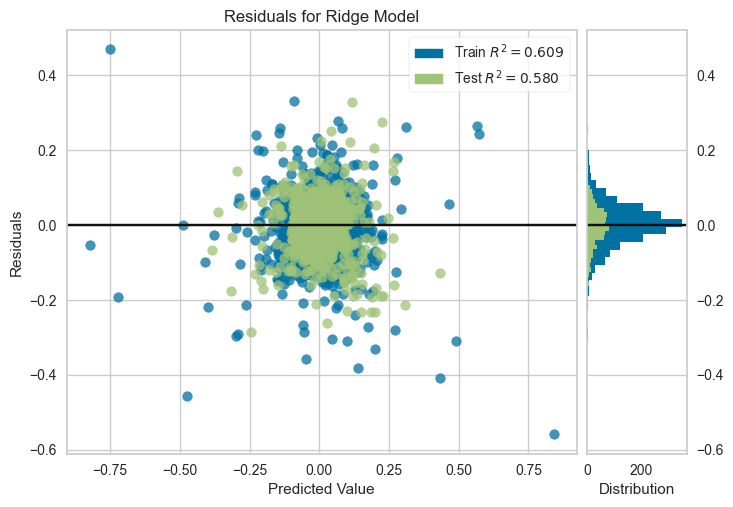

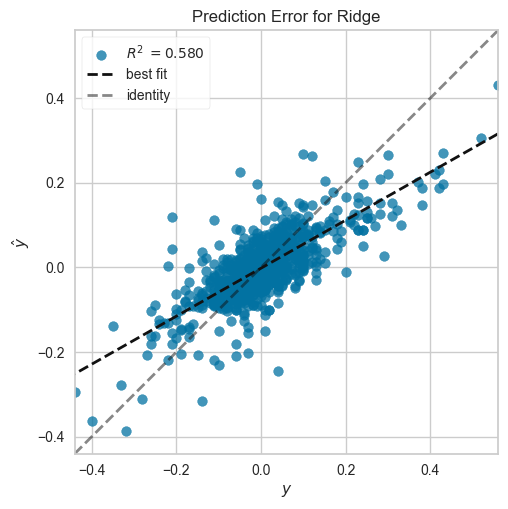

In [ ]:
# target_col = 'MORTGAGE30US_diff'
# source = '../data/full_mortgage_dataset.csv'

# # Load and preprocess data
# df = load_and_preprocess_data(source, target_col)
# df = create_features(df, target_col)

# # Ensure all columns are numeric and handle any non-numeric data
# df = df.apply(pd.to_numeric, errors='coerce')
# df.fillna(0, inplace=True)  # Fill NaN values created by coercion

# reg_setup = setup(
#     data=df,
#     target=target_col,
#     session_id=42,
#     fold=10,
#     use_gpu=False,
#     categorical_imputation='drop',
#     numeric_imputation='drop',
#     normalize=True,
#     transformation=False,
#     feature_selection=False,
#     remove_multicollinearity=False,
#     ignore_features=['date'],
#     )

# ridge_reg = create_model('ridge')
# tuned_ridge = tune_model(ridge_reg, n_iter=100, optimize='MAE')

# Implement Bayesian Ridge Regression
Below is a Python implementation that mimics the Bayesian Ridge Regression workflow used by PyCaret, using libraries like pandas, scikit-learn, and matplotlib for preprocessing, training, testing, and visualization.

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [24]:
# Train and evaluate Bayesian Ridge Regression
def train_and_evaluate_models(df: pd.DataFrame, target_col: str):
    # Split data into features and target
    X = df.drop(columns=[target_col])
    y = df[target_col]
    
    # Split into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
        )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Bayesian Ridge Regression
    bayesian_model = BayesianRidge()
    bayesian_model.fit(X_train_scaled, y_train)
    bayesian_pred = bayesian_model.predict(X_test_scaled)
    
    # Train Linear Regression
    linear_model = LinearRegression()
    linear_model.fit(X_train_scaled, y_train)
    linear_pred = linear_model.predict(X_test_scaled)
    
    # Evaluate both models
    models = {
        "Bayesian Ridge Regression": (bayesian_model, bayesian_pred),
        "Linear Regression": (linear_model, linear_pred)
    }
    
    results = {}
    for model_name, (model, pred) in models.items():
        rmse = np.sqrt(mean_squared_error(y_test, pred))
        mae = mean_absolute_error(y_test, pred)
        r2 = r2_score(y_test, pred)
        results[model_name] = {"RMSE": rmse, "MAE": mae, "R2": r2}
        print(f"{model_name} - RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")

    # Save the models
    joblib.dump(bayesian_model, '../models/bayesian_ridge_model.pkl')
    joblib.dump(linear_model, '../models/linear_regression_model.pkl')
    
    return models, results, X_test, y_test

In [22]:
# Visualization functions
def plot_predictions(y_test, predictions, model_names):
    plt.figure(figsize=(10, 6))
    for pred, name in zip(predictions, model_names):
        plt.scatter(y_test, pred, alpha=0.7, label=name)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def plot_residuals(y_test, predictions, model_names):
    plt.figure(figsize=(10, 6))
    for pred, name in zip(predictions, model_names):
        residuals = y_test - pred
        sns.histplot(residuals, bins=30, kde=True, label=name, alpha=0.6)
    plt.xlabel('Residuals')
    plt.title('Residuals Distribution')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Bayesian Ridge Regression - RMSE: 0.0674, MAE: 0.0499, R2: 0.5637
Linear Regression - RMSE: 0.0675, MAE: 0.0503, R2: 0.5620


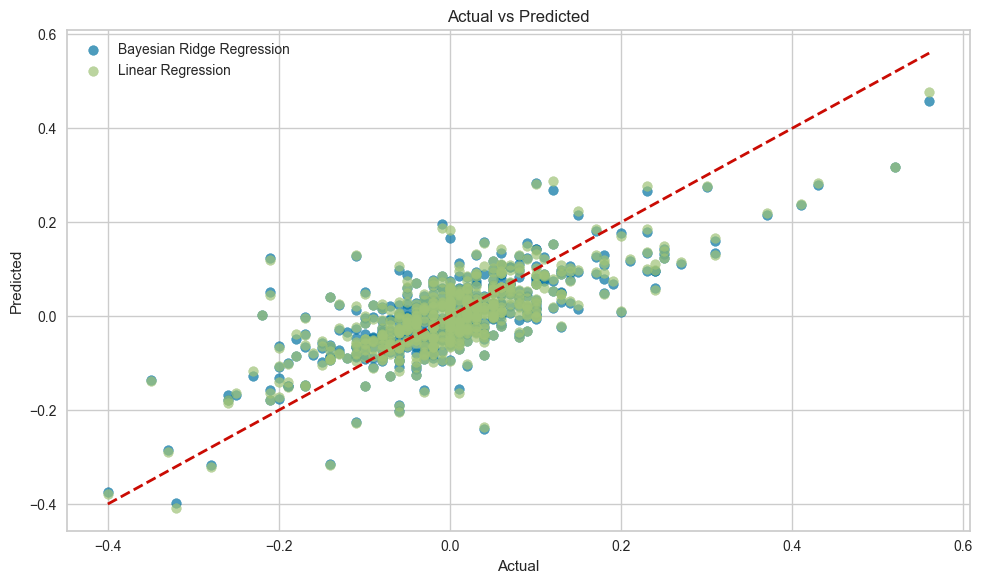

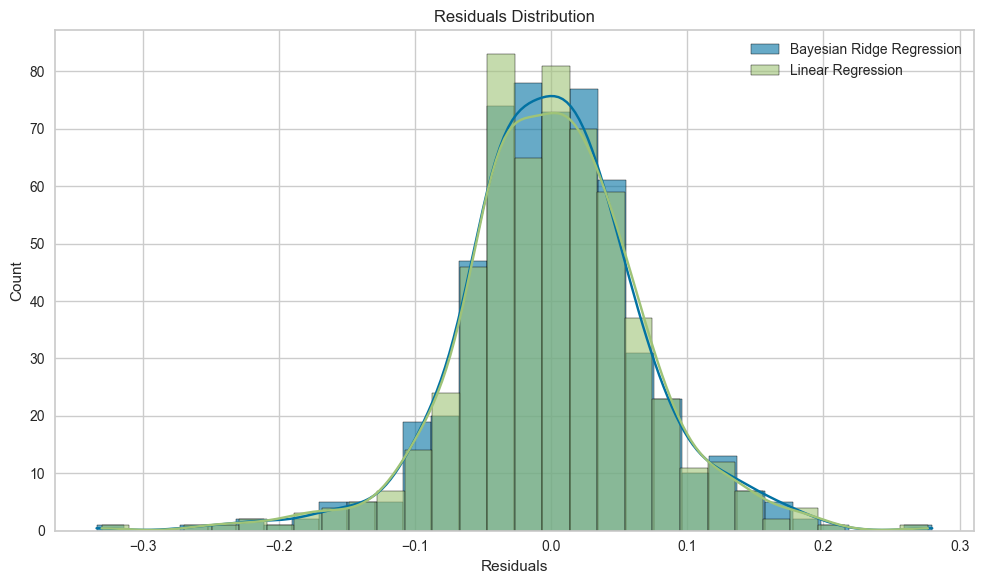

In [25]:
target_col = 'MORTGAGE30US_diff'
source = '../data/full_mortgage_dataset.csv'

# Load and preprocess data
df = load_and_preprocess_data(source, target_col)
df = create_features(df, target_col)
df.fillna(0, inplace=True)  # Fill NaN values created by rolling features

# Train and evaluate models
models, results, X_test, y_test = train_and_evaluate_models(df, target_col)

# Visualize results
predictions = [models["Bayesian Ridge Regression"][1], models["Linear Regression"][1]]
model_names = ["Bayesian Ridge Regression", "Linear Regression"]
plot_predictions(y_test, predictions, model_names)
plot_residuals(y_test, predictions, model_names)